# Visualise 

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import torch

print(os.getcwd())
data_root = os.path.join(os.getcwd(), 'ZooTransform')

sys.path.append(data_root)

from src.zootransform.fine_tuning.fine_tuning import LoraFinetunerMLM  # new MLM version
from src.zootransform.model.species_model import SpeciesAwareESM2
from src.zootransform.dataset.load_uniprot import load_uniprot

/home/hslab/Olive/Kode/ZooTransform


/home/hslab/Olive/Kode/ZooTransform/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All libraries imported successfully!


In [2]:
data = load_uniprot()
species_names = sorted(set(data['species'].unique().tolist()))
species_model = SpeciesAwareESM2(model_name="facebook/esm2_t6_8M_UR50D", species_list=species_names) #TODO - define species list

species_batch = data["species"].tolist()
sequence_batch = data["sequence"].tolist()

Using device: cuda
  GPU: NVIDIA GeForce RTX 4090
  Memory: 25.39 GB
Loading model: facebook/esm2_t6_8M_UR50D


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Adding species tokens: ['<sp_Arabidopsis thaliana>', '<sp_Bos taurus>', '<sp_Escherichia coli>', '<sp_Homo sapiens>', '<sp_Mus musculus>', '<sp_Oryza sativa>', '<sp_Rattus norvegicus>', '<sp_Rhodotorula toruloides>', '<sp_Saccharolobus solfataricus>', '<sp_Saccharomyces cerevisiae>', '<sp_Schizosaccharomyces pombe>', '<sp_Staphylococcus aureus>']
Added 12 new special tokens
Resized model embeddings to 45 tokens
✓ Model and tokenizer ready!
  Hidden size: 320
  Number of layers: 6


/tmp/ipykernel_1704652/432162726.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=data['species'].value_counts().index, x=data['species'].value_counts().values,


<Axes: ylabel='species'>

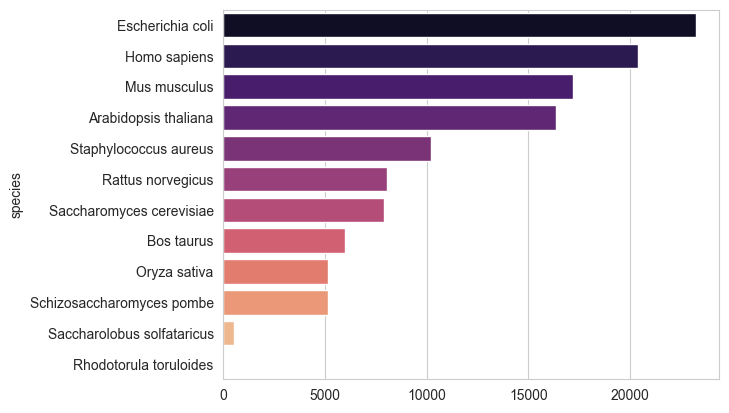

In [3]:
import seaborn as sns

sns.barplot(y=data['species'].value_counts().index, x=data['species'].value_counts().values,
            palette='magma')

In [4]:
from typing import Optional, Sequence, Union, Mapping, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap


X = sequence_batch[:4000]

# --- UMAP embedding ---
random_state = 0
n_neighbors = 15
min_dist = 0.1
n_components = 2
metric = 'euclidean'
reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    metric=metric,
    random_state=random_state,
)
embedding_2d = reducer.fit_transform(X)  # shape (N, 2)



ValueError: could not convert string to float: 'MKNLSVVTQFILLGIPHTEGVETMLFVLFFSFYIFTLVGNLLILLAIVSSSRLHTPMYFFLCQLSVCDIFFPSVSSPKMLFYLSGNTPAISYAGCVSQLFFYHFLGGTECFLYTVMAYDRFVAICYPLRYSVIMSHRICAFLAMGTAVFGCIHSTFLTTLTFQLPYCGPKDVNYYFCDIPVVMKLACADTSTLEMVGFISVGLMPLSCFFFILTSYSCIVRSILQIRSTEGRHRAFSTCSAHFTAILLFYMPVIFIYLRPTPSPWLDATVQILNNLVTPMLNPLIYSLRNKEVKSSLWTVLHLLCFLPKHL'

# Get embeddings and plot UMAP

In [3]:
from src.zootransform.fine_tuning.fine_tuning import ProteinDataset
from src.zootransform.fine_tuning.fine_tuning import LoraFinetunerMLM  # new MLM version

device = "cuda" if torch.cuda.is_available() else "cpu"

# Species-aware model
species_model = SpeciesAwareESM2(species_list=species_names)
species_model.model.to(device)

finetuner = LoraFinetunerMLM(
    base_model=species_model,
    r=8,
    alpha=16,
    dropout=0.05,
    target_modules=["attention.self.key", "attention.self.value", "attention.self.query", "embeddings.word_embeddings"],  # LoRA targets
    lr=1e-4,
    batch_size=4,
    mlm_probability=0.15  # fraction of tokens to mask
)

tuned_embeddings = finetuner.embed(species_batch, sequence_batch)
print("Tuned embeddings shape:", tuned_embeddings.shape)

dataset = ProteinDataset(
            species_batch=[f"<sp_{s}>" for s in species_batch],
            sequence_batch=sequence_batch,
            tokenizer=finetuner.tokenizer,
            max_length=finetuner.max_length
        )
# embeddings = species_model.embed(species_batch, sequence_batch)

Using device: cuda
  GPU: NVIDIA GeForce RTX 4090
  Memory: 25.39 GB
Loading model: facebook/esm2_t6_8M_UR50D


Adding species tokens: ['<sp_Arabidopsis thaliana>', '<sp_Bos taurus>', '<sp_Escherichia coli>', '<sp_Homo sapiens>', '<sp_Mus musculus>', '<sp_Oryza sativa>', '<sp_Rattus norvegicus>', '<sp_Rhodotorula toruloides>', '<sp_Saccharolobus solfataricus>', '<sp_Saccharomyces cerevisiae>', '<sp_Schizosaccharomyces pombe>', '<sp_Staphylococcus aureus>']
Added 12 new special tokens
Resized model embeddings to 45 tokens
✓ Model and tokenizer ready!
  Hidden size: 320
  Number of layers: 6
Tuned embeddings shape: torch.Size([120095, 320])


In [ ]:
embeddings = species_model.embed(species_batch, sequence_batch)
len(dataset[0]['input_ids'])

1024

In [ ]:
from typing import Optional, Sequence, Union, Mapping, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

def plot_embeddings_umap(
    embeddings: Union[np.ndarray, Sequence[np.ndarray], pd.DataFrame],
    species: Union[Sequence[str], pd.Series, None] = None,
    *,
    n_neighbors: int = 15,
    min_dist: float = 0.1,
    n_components: int = 2,
    metric: str = "cosine",
    pca_pre: Optional[int] = 50,
    scale: bool = True,
    figsize: tuple = (8, 6),
    point_size: float = 8.0,
    show_centroids: bool = True,
    annotate: bool = False,
    random_state: int = 42,
    cmap: Optional[str] = None,
    title: Optional[str] = None,
) -> tuple:
    """
    Project embeddings to 2D using UMAP and plot colored by `species` labels.

    Parameters
    ----------
    embeddings
        Either a (N, D) numpy array, a pandas DataFrame with embedding columns,
        or a sequence of embeddings (which will be stacked).
    species
        Sequence of categorical labels (length N) or a pandas Series. If None,
        points are plotted without labels (single color).
    n_neighbors, min_dist, n_components, metric
        UMAP parameters.
    pca_pre
        If provided, run PCA to reduce dimensionality to `pca_pre` before UMAP.
        Useful when D is large.
    scale
        If True, standardize features before UMAP.
    figsize
        Matplotlib figure size.
    point_size
        Scatter point size.
    show_centroids
        If True and species provided, plot species centroids and label them.
    annotate
        If True, annotate each point with its index (useful for debugging; avoid for large N).
    random_state
        RNG seed for reproducibility.
    cmap
        Optional matplotlib colormap name for categorical colors; if None, uses default color cycle.
    title
        Optional plot title.

    Returns
    -------
    (fig, ax)
        Matplotlib figure and axis objects.
    """
    # --- Normalize/prepare embeddings array ---
    if isinstance(embeddings, pd.DataFrame):
        X = embeddings.values
    elif isinstance(embeddings, (list, tuple)):
        X = np.vstack([np.asarray(e) for e in embeddings])
    else:
        X = np.asarray(embeddings)

    if X.ndim != 2:
        raise ValueError("embeddings must be a 2D array-like of shape (N, D)")

    n_samples = X.shape[0]

    # --- Prepare labels ---
    if species is not None:
        y = pd.Series(species).astype("category").reset_index(drop=True)
        if len(y) != n_samples:
            raise ValueError("Length of `species` must match number of embeddings")
        categories = y.cat.categories
        cat_codes = y.cat.codes.values  # integers 0..K-1
        n_cats = len(categories)
    else:
        y = None
        cat_codes = None
        n_cats = 1

    # --- Optional scaling ---
    X_proc = X.astype(float)
    if scale:
        X_proc = StandardScaler().fit_transform(X_proc)

    # --- Optional PCA pre-reduction ---
    if pca_pre is not None and pca_pre > 0 and X_proc.shape[1] > pca_pre:
        pca = PCA(n_components=pca_pre, random_state=random_state)
        X_proc = pca.fit_transform(X_proc)

    # --- UMAP embedding ---
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=random_state,
    )
    embedding_2d = reducer.fit_transform(X_proc)  # shape (N, 2)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=figsize)
    if y is None:
        ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=point_size, alpha=0.8)
    else:
        # Choose colors: matplotlib default cycle or a categorical cmap if provided
        if cmap:
            cmap_obj = plt.get_cmap(cmap)
            colors = [cmap_obj(i / max(1, n_cats - 1)) for i in range(n_cats)]
        else:
            # use the default property cycle
            prop_cycle = plt.rcParams["axes.prop_cycle"]
            colors_cycle = prop_cycle.by_key().get("color", None)
            if colors_cycle is None:
                colors = plt.cm.tab10.colors[:n_cats]
            else:
                # repeat cycle if n_cats > len(colors_cycle)
                colors = [colors_cycle[i % len(colors_cycle)] for i in range(n_cats)]

        for cat_idx, cat in enumerate(categories):
            mask = (cat_codes == cat_idx)
            ax.scatter(
                embedding_2d[mask, 0],
                embedding_2d[mask, 1],
                label=str(cat),
                s=point_size,
                alpha=0.85,
                color=colors[cat_idx],
                edgecolors="none",
            )

        if show_centroids:
            centroids = []
            for cat_idx in range(n_cats):
                mask = (cat_codes == cat_idx)
                if mask.sum() == 0:
                    centroids.append(np.array([np.nan, np.nan]))
                    continue
                centroid = embedding_2d[mask].mean(axis=0)
                centroids.append(centroid)
                ax.scatter(
                    centroid[0],
                    centroid[1],
                    marker="X",
                    s=point_size * 4,
                    color=colors[cat_idx],
                    edgecolors="black",
                    linewidths=0.6,
                    zorder=5,
                )
                # label the centroid
                ax.text(
                    centroid[0],
                    centroid[1],
                    str(categories[cat_idx]),
                    fontsize=9,
                    fontweight="bold",
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="white" if _is_dark_color(colors[cat_idx]) else "black",
                    bbox=dict(boxstyle="round,pad=0.2", fc=colors[cat_idx], ec="none", alpha=0.8),
                    zorder=6,
                )

        ax.legend(title="species", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.0)

    if annotate:
        # annotate each point with its index
        for i, (x0, y0) in enumerate(embedding_2d):
            ax.text(x0 + 0.002, y0 + 0.002, str(i), fontsize=6)

    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    if title is not None:
        ax.set_title(title)
    ax.grid(False)
    plt.tight_layout()
    return fig, ax


def _is_dark_color(color: Any) -> bool:
    """
    Helper: decide whether a color is dark for text contrast.
    Accepts matplotlib color specs (hex or RGB tuple).
    """
    # convert to RGB tuple
    try:
        import matplotlib.colors as mcolors

        rgb = mcolors.to_rgb(color)
    except Exception:
        # fallback to black
        return False
    # perceieved brightness (luma)
    r, g, b = rgb
    luma = 0.299 * r + 0.587 * g + 0.114 * b
    return luma < 0.5


In [ ]:
# embeddings: numpy array shape (N, D)
# species: list/Series of labels length N
fig, ax = plot_embeddings_umap(
    embeddings=embeddings,
    species=species_batch,
    pca_pre=50,
    n_neighbors=30,
    min_dist=0.05,
    cmap="tab20",
    title="Protein embeddings UMAP by species",
)
fig.savefig("umap_species.png", dpi=300, bbox_inches="tight")
